In [1]:
%load_ext autoreload
%autoreload 2

In [81]:
import os, math, random, numpy as np
import importlib
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import sys
import h5py
from pathlib import Path
import zipfile, os, sys
from collections import defaultdict, Counter
import re
import json
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import random
from statistics import mean
from torch.optim.lr_scheduler import LambdaLR

os.environ["TQDM_NOTEBOOK"] = "0"

ROOT = Path.cwd().parent          
SRC  = ROOT / "src"
sys.path.insert(0, str(SRC))     

from fashiongen_h5_loader import (
    ensure_h5_ready, build_vocab_from_h5, build_material_vocab_from_h5, make_loaders_with_existing_val, read_label_ids_from_h5, fast_material_counts

)

# v1: the backbone/existing code (kept unchanged)
from multitask_fashion_model_v1 import (
    FashionMultiTaskModel, MultiTaskConfig, collate_batch, TextTokenizer, worker_init_fn
)

# v2: extras 
from multitask_fashion_model_v2.losses import LabelSmoothingCE, FocalLoss
from multitask_fashion_model_v2.aug import mixup_or_cutmix, _mixup_crit
from multitask_fashion_model_v2.patch_pool import MaterialSidecar, PatchAttentionPool
from multitask_fashion_model_v2.balance import MovingAverageLossScaler
from multitask_fashion_model_v2 import decoding as dec
from multitask_fashion_model_v2.step import train_one_step
from multitask_fashion_model_v2.evaluate import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


# 1. Set Seed

In [3]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); 
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2. Import Data and Map

In [4]:
DATA_DIR = ROOT / "data"
assert DATA_DIR.exists(), f"Missing data dir: {DATA_DIR}"
print("DATA_DIR:", DATA_DIR)

DATA_DIR: /home/jiaqing/codebase/Shop-Till-You-Drop/data


In [5]:
train_h5 = DATA_DIR / "fashiongen_256_256_train.h5" / "fashiongen_256_256_train.h5"
val_h5   = DATA_DIR / "fashiongen_256_256_validation.h5" / "fashiongen_256_256_validation.h5"
print("train_h5:", train_h5)
print("val_h5  :", val_h5)


train_h5: /home/jiaqing/codebase/Shop-Till-You-Drop/data/fashiongen_256_256_train.h5/fashiongen_256_256_train.h5
val_h5  : /home/jiaqing/codebase/Shop-Till-You-Drop/data/fashiongen_256_256_validation.h5/fashiongen_256_256_validation.h5


In [6]:
label_vocab_path = ROOT / "artifacts/label_vocab.json"
gender_vocab_path = ROOT / "artifacts/gender_vocab.json"
mat_vocab_path = ROOT / "artifacts/material_vocab.json"

In [7]:
# Build id → name map
with open(label_vocab_path) as f:
    label_vocab = json.load(f)
    
id2label = {int(v): k for k, v in label_vocab.items()}

In [8]:
with open(gender_vocab_path) as f:
    gen_vocab = json.load(f)
id2gen = {int(v): k for k, v in gen_vocab.items()}

In [9]:
with open(mat_vocab_path) as f:
    mat_vocab = json.load(f)
id2mat = {int(v): k for k, v in mat_vocab.items()}

In [75]:
META_KEYS = ( "input_category", "input_name", "input_description", "input_gender")  

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders_with_existing_val(
    train_h5=train_h5,
    val_h5=val_h5,
    vocab_label_json=str(label_vocab_path),
    vocab_gender_json=str(gender_vocab_path),
    material_vocab_json=str(mat_vocab_path),    
    composition_key="input_composition",
    materials_clothing_only=True,
    image_key="input_image",
    label_key="input_category",
    caption_key_candidates=("input_name","input_description","input_concat_description","caption","descriptions"),
    label_key_candidates=("input_category","category","class","label"),
    meta_keys=META_KEYS,
    meta_prefix="input_",
    image_size=224,
    train_ratio=0.8,
    batch_size=64,
    num_workers=8,
    normalize="imagenet",
)
print("train/val/test lens:", len(train_ds), len(val_ds), len(test_ds))

train/val/test lens: 208383 32528 52107


In [11]:
print("image_key:", train_ds.image_key)
print("label_key:", train_ds.label_key)
print("caption_key:", train_ds.caption_key)
print("composition_key:", train_ds.composition_key)

image_key: input_image
label_key: input_category
caption_key: input_name
composition_key: input_composition


In [12]:
b = next(iter(train_loader))

In [13]:
print(b["image"].shape, b["label"].shape, b['gender'].shape, b['material'].shape)

torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64]) torch.Size([64])


In [14]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_img(img_t: torch.Tensor, norm="imagenet"):
    if norm == "imagenet":
        x = img_t * IMAGENET_STD + IMAGENET_MEAN
    elif norm == "gan":
        x = (img_t * 0.5) + 0.5
    else:
        x = img_t
    return x.clamp(0,1)

def show_samples(ds, idxs=None, n=8, ncols=4, norm="imagenet", id2label=None, figsize=(14, 8)):
    """
    idxs refer to **dataset indices**: 0..len(ds)-1.
    If idxs is None, we sample uniformly from that range.
    """
    N = len(ds)
    if idxs is None:
        n = min(n, N)
        idxs = np.random.default_rng(0).choice(np.arange(N), size=n, replace=False)
    else:
        idxs = [int(i) for i in idxs]
        for i in idxs:
            if not (0 <= i < N):
                raise IndexError(f"Dataset index {i} out of range [0, {N})")

    n = len(idxs)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols

    plt.figure(figsize=figsize)
    for pos, i in enumerate(idxs, 1):
        ex = ds[i]  # safe: dataset index
        img = denorm_img(ex["image"], norm=norm).permute(1,2,0).cpu().numpy()
        y = ex["label"]
        yname = id2label.get(int(y), str(y)) if id2label is not None else str(y)
        cap = ex.get("caption", "")
        cap = cap if isinstance(cap, str) else str(cap)
        if len(cap) > 80: cap = cap[:80] + "…"

        ax = plt.subplot(nrows, ncols, pos)
        ax.imshow(img); ax.axis("off")
        ax.set_title(f"{y} | {yname}", fontsize=10)
        ax.set_xlabel(cap, fontsize=9)
    plt.tight_layout()
    plt.show()

def show_by_raw_index(ds, raw_idxs, **kw):
    """
    Peek items by **raw H5 indices** (values inside ds.keep_idx).
    We convert each raw index to its dataset index first.
    """
    raw_idxs = [int(r) for r in raw_idxs]
    keep = np.asarray(ds.keep_idx)
    inv = {int(k): j for j, k in enumerate(keep)}  # raw->dataset
    ds_idxs = []
    missing = []
    for r in raw_idxs:
        j = inv.get(int(r))
        if j is None:
            missing.append(r)
        else:
            ds_idxs.append(j)
    if missing:
        print(f"(skipped {len(missing)} raw indices not in subset): {missing[:10]}")
    return show_samples(ds, idxs=ds_idxs, **kw)

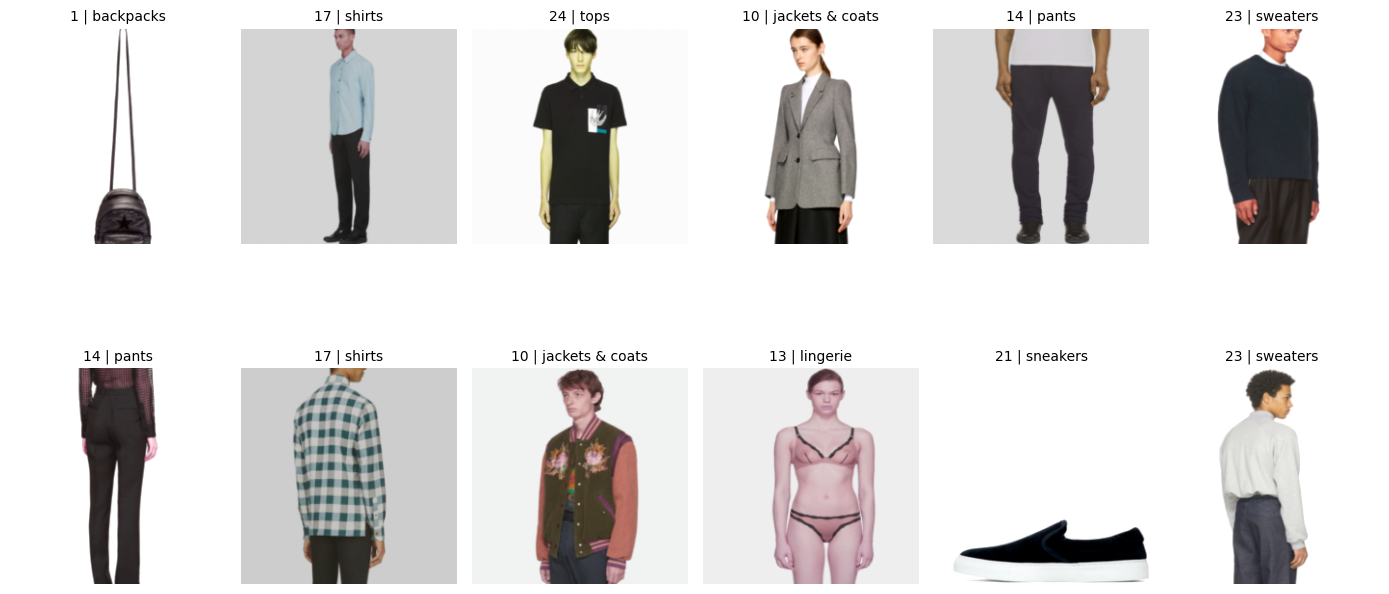

In [15]:
show_samples(train_ds, n=12, ncols=6, norm="imagenet", id2label=id2label)

# 2. Build the Model

In [16]:
# 1) Build tokenizer from the train dataset captions
# captions = [train_ds[i]["caption"] for i in tqdm(range(len(train_ds)))]

In [17]:
# tok =  TextTokenizer.build_from_captions(captions=captions, min_freq=2, max_size=30000)

In [18]:
import json, os
# os.makedirs("artifacts", exist_ok=True)
# with open("artifacts/tokenizer.json","w") as f:
#     json.dump({"stoi": tok.stoi}, f)

# load later
with open("artifacts/tokenizer.json") as f:
    stoi = json.load(f)["stoi"]
tok = TextTokenizer(stoi)

In [19]:
print(len(tok.stoi), list(tok.stoi)[:10])

13373 ['<pad>', '<bos>', '<eos>', '<unk>', 'black', 'white', 't-shirt', '&', 'jacket', 'grey']


In [25]:
## 2) Create model config (enable/disable heads based on vocabs)
cfg = MultiTaskConfig(
    backbone="vit_base_patch16_224",
    proj_dim=512,
    num_categories=len(label_vocab),
    num_genders=len(gen_vocab),
    num_materials=len(mat_vocab), 
    vocab_size=len(tok.stoi),
    pad_id=tok.pad_id,
    caption_emb_dim=256,
    caption_layers=1,
    dropout=0.1,
    loss_w_category=1.0,
    loss_w_gender=0.5,
    loss_w_material=2.0,
    loss_w_caption=1.3,
)

model = FashionMultiTaskModel(cfg).to(device)

USE_SIDE_MATERIAL = True      # small ViT sidecar that pools patch tokens for material
USE_DYNAMIC_BAL   = True      # EMA scaling so one loss head doesn't dominate
MATERIAL_LOSS     = "labelsmooth"  # "ce" | "labelsmooth" | "focal"
MIXUP_P, CUTMIX_P = 0.4, 0.2
DECODE_MODE       = "beam"    # "greedy" | "beam" | "nucleus"
MAX_LEN           = 20

sidecar  = MaterialSidecar(out_dim=cfg.proj_dim).to(device) if USE_SIDE_MATERIAL else None
balancer = MovingAverageLossScaler(warmup_steps=100) if USE_DYNAMIC_BAL else None

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [82]:
# 3) DataLoaders with collate
def collate_with_meta(samples, tokenizer, expect_category, expect_gender, expect_material):
    batch = collate_batch(samples, tokenizer, expect_category, expect_gender, expect_material)
    batch["meta"] = [s.get("meta", {}) for s in samples]
    batch["caption_raw"] = [s.get("caption", "") for s in samples]
    return batch

collate_fn = partial(
    collate_with_meta,          
    tokenizer=tok,
    expect_category=(cfg.num_categories is not None),
    expect_gender=(cfg.num_genders is not None),
    expect_material=(cfg.num_materials is not None),
)


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,  
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,
)

print("Loaders rebuilt with custom collate:",
      len(train_ds), len(val_ds), len(test_ds))

Loaders rebuilt with custom collate: 208383 32528 52107


In [27]:
# 4) Material class weights from training set
mat_counts, missing = fast_material_counts(train_ds)
num_mat = len(train_ds.material_vocab)
counts_material = torch.tensor(
    [mat_counts.get(i, 1) for i in range(num_mat)], dtype=torch.float, device=device
)

def class_weights_from_counts(counts: torch.Tensor):
    w = 1.0 / (counts + 1e-6)
    w = (w / w.sum()) * len(w)   # mean ≈ 1
    return w

material_class_weights = class_weights_from_counts(counts_material)
print("Built material_class_weights:", tuple(material_class_weights.shape), "missing:", missing)

Built material_class_weights: (8,) missing: 0


In [23]:
# Convert vocab id→name
id2mat = {v: k for k, v in mat_vocab.items()}

# Build dense count vector for all materials
all_counts = {id2mat[i]: mat_counts.get(i, 0) for i in range(len(mat_vocab))}

df_mat_all = pd.DataFrame([
    {"material_name": id2mat[i], "count": mat_counts.get(i, 0)}
    for i in range(len(mat_vocab))
]).sort_values("count", ascending=False).reset_index(drop=True)

display(df_mat_all)


,material_name,count
0,cotton,96693
1,leather,34012
2,wool,23430
3,__other__,15420
4,polyester,15141
5,nylon,11703
6,viscose,11599
7,elastane,385


In [28]:
# --------------------------
# Optimizer (param groups)
#   - lower LR on backbone
#   - higher LR on heads/decoder
# --------------------------
backbone_params = list(model.backbone.parameters())
head_params = [p for n, p in model.named_parameters() if not n.startswith("backbone.")]
if sidecar is not None:
    head_params += list(sidecar.parameters())

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-4},
        {"params": head_params,     "lr": 3e-4},
    ],
    weight_decay=1e-4,
    betas=(0.9, 0.98),
)


In [31]:
# --------------------------
# Scheduler: warmup + cosine
# --------------------------

steps_per_epoch = max(1, len(train_loader))
EPOCHS = 10
total_steps  = steps_per_epoch * EPOCHS
warmup_steps = int(0.10 * total_steps)  # 10% warmup

def lr_lambda(step):
    if step < warmup_steps:
        return (step + 1) / float(max(1, warmup_steps))
    t = (step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1 + math.cos(math.pi * t))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [32]:
# --------------------------
# Freeze backbone
#   (stabilize first 3 epochs)
# --------------------------
def set_backbone_trainable(m, trainable: bool):
    for p in m.backbone.parameters():
        p.requires_grad = trainable

FREEZE_EPOCHS = 3
set_backbone_trainable(model, trainable=False)  # freeze at start

In [33]:
def score_fn(m):
    s = 0.0
    s += 0.5 * m.get("material_top1", 0.0)
    s += 0.3 * m.get("category_top1", 0.0)
    s += 0.2 * m.get("gender_top1", 0.0)
    if "caption_ppl" in m:
        s += 0.2 * (1.0 / (1.0 + m["caption_ppl"]))
    return s

def caption_ppl_inv(m):
    if "caption_ppl" not in m: return 0.0
    return 1.0 / (1.0 + m["caption_ppl"])

def overall_score(m):
    return (m['category_top1'] + m['gender_top1'] + m['material_top1'])/3.0 + (1.0 / max(1e-6, m['caption_ppl']))


In [34]:
best_score = -1e9
patience, bad = 3, 0
BEST_OVERALL = {"score": -float("inf"), "epoch": 0}
BEST_HEADS = {
    "category_top1": {"score": -float("inf"), "epoch": 0},
    "gender_top1":   {"score": -float("inf"), "epoch": 0},
    "material_top1": {"score": -float("inf"), "epoch": 0},
    "caption_ppl_inv": {"score": -float("inf"), "epoch": 0},
}
SCORES = []
_last_val_for_bar = {}


In [37]:
os.makedirs("runs", exist_ok=True)

# --------------------------
# Training loop
# --------------------------
global_step = 0
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    if epoch == FREEZE_EPOCHS + 1:
        set_backbone_trainable(model, trainable=True)  # unfreeze

    model.train()
    totals = []
    bar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"[Epoch {epoch}/{EPOCHS}]")

    for step, batch in bar:
        logs = train_one_step(
            model, batch, optimizer, tok, device,
            sidecar=sidecar,
            material_loss_kind=MATERIAL_LOSS,
            mixup_p=MIXUP_P, cutmix_p=CUTMIX_P,
            w_cat=cfg.loss_w_category, w_gen=cfg.loss_w_gender,
            w_mat=cfg.loss_w_material, w_cap=cfg.loss_w_caption,
            class_weights_mat=material_class_weights,
            balancer=balancer,
            decode_mode=DECODE_MODE,   # if your train step does any scheduled sampling/aux decode
        )
        totals.append(logs["total"])

        # advance scheduler per-iteration
        global_step += 1
        scheduler.step()

        # lr for display
        lr = max(pg["lr"] for pg in optimizer.param_groups)
        bar_post = {
            "train_total": f"{logs['total']:.3f}",
            "mat": f"{logs.get('material_ce', 0.0):.3f}",
            "cap": f"{logs.get('caption_nll', 0.0):.3f}",
            "lr": f"{lr:.1e}",
            "aug": logs.get("mix_mode", "none"),
        }
        if _last_val_for_bar:
            bar_post.update({
                "v_cat": f"{_last_val_for_bar.get('category_top1',0):.3f}",
                "v_gen": f"{_last_val_for_bar.get('gender_top1',0):.3f}",
                "v_mat": f"{_last_val_for_bar.get('material_top1',0):.3f}",
                "v_ppl": f"{_last_val_for_bar.get('caption_ppl',0):.2f}",
            })
        bar.set_postfix(bar_post)

    avg_total = mean(totals) if totals else float("nan")
    print(f"\n[Epoch {epoch}] train_total={avg_total:.4f}")

    # --------- VALIDATE ----------
    val_metrics = evaluate(
        model, val_loader, tokenizer=tok, device=device,
        decode_mode=DECODE_MODE,  # "beam" uses your beam generator under the hood
        max_len=MAX_LEN
    )
    pretty = {k: (round(v,4) if isinstance(v, float) else v) for k, v in val_metrics.items()}
    print("Val metrics:", pretty)

    _last_val_for_bar = {
        "category_top1": val_metrics.get("category_top1", 0.0),
        "gender_top1":   val_metrics.get("gender_top1", 0.0),
        "material_top1": val_metrics.get("material_top1", 0.0),
        "caption_ppl":   val_metrics.get("caption_ppl", float("inf")),
    }

    record = {"epoch": epoch, **val_metrics}
    record["overall_score"] = score_fn(val_metrics)
    record["caption_ppl_inv"] = caption_ppl_inv(val_metrics)
    SCORES.append(record)
    with open("runs/val_history.jsonl", "a") as f:
        f.write(json.dumps(record) + "\n")

    # best-overall checkpoint
    cur_score = record["overall_score"]
    if cur_score > BEST_OVERALL["score"]:
        BEST_OVERALL.update({"score": cur_score, "epoch": epoch})
        torch.save({"model": model.state_dict(), "cfg": cfg.__dict__, "val_metrics": val_metrics},
                   "runs/best_overall.pt")
        print(f"✅ Saved new BEST OVERALL at epoch {epoch} (overall_score={cur_score:.4f})")
        bad = 0
    else:
        bad += 1
        if bad >= 3:
            print("Early stopping (no overall improvement).")
            break

    # per-head bests
    head_targets = {
        "category_top1": record.get("category_top1", 0.0),
        "gender_top1":   record.get("gender_top1", 0.0),
        "material_top1": record.get("material_top1", 0.0),
        "caption_ppl_inv": record.get("caption_ppl_inv", 0.0),
    }
    for key, val in head_targets.items():
        if val > BEST_HEADS[key]["score"]:
            BEST_HEADS[key].update({"score": val, "epoch": epoch})
            ckpt_path = f"runs/best_{key}.pt"
            torch.save({"model": model.state_dict(), "cfg": cfg.__dict__, "val_metrics": val_metrics}, ckpt_path)
            print(f"Saved new best for {key} at epoch {epoch}: {val:.4f} -> {ckpt_path}")

print(f"\nBest overall: epoch {BEST_OVERALL['epoch']} (score={BEST_OVERALL['score']:.4f})")
print("Best per head:", {k: (v['epoch'], round(v['score'], 4)) for k, v in BEST_HEADS.items()})

[Epoch 1/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 1] train_total=5.1059


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6601, 'gender_top1': 0.8398, 'material_top1': 0.0712, 'caption_nll_per_token': 3.4191, 'caption_ppl': 30.5419, 'BLEU-1': 0.2208, 'BLEU-2': 0.0319, 'BLEU-4': 0.0001, 'ROUGE-L_P': 0.3793, 'ROUGE-L_R': 0.2502, 'ROUGE-L_F1': 0.2954}
✅ Saved new BEST OVERALL at epoch 1 (overall_score=0.4079)
Saved new best for category_top1 at epoch 1: 0.6601 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 1: 0.8398 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 1: 0.0712 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 1: 0.0317 -> runs/best_caption_ppl_inv.pt


[Epoch 2/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 2] train_total=4.7952


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6744, 'gender_top1': 0.8484, 'material_top1': 0.1201, 'caption_nll_per_token': 3.1284, 'caption_ppl': 22.8373, 'BLEU-1': 0.2496, 'BLEU-2': 0.0424, 'BLEU-4': 0.0002, 'ROUGE-L_P': 0.411, 'ROUGE-L_R': 0.2796, 'ROUGE-L_F1': 0.3263}
✅ Saved new BEST OVERALL at epoch 2 (overall_score=0.4404)
Saved new best for category_top1 at epoch 2: 0.6744 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 2: 0.8484 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 2: 0.1201 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 2: 0.0420 -> runs/best_caption_ppl_inv.pt


[Epoch 3/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 3] train_total=4.7979


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.6782, 'gender_top1': 0.8524, 'material_top1': 0.0995, 'caption_nll_per_token': 3.0379, 'caption_ppl': 20.8611, 'BLEU-1': 0.2602, 'BLEU-2': 0.0467, 'BLEU-4': 0.0005, 'ROUGE-L_P': 0.4197, 'ROUGE-L_R': 0.2898, 'ROUGE-L_F1': 0.3362}
Saved new best for category_top1 at epoch 3: 0.6782 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 3: 0.8524 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 3: 0.0457 -> runs/best_caption_ppl_inv.pt


[Epoch 4/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 4] train_total=4.7830


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.7591, 'gender_top1': 0.9447, 'material_top1': 0.1427, 'caption_nll_per_token': 2.8994, 'caption_ppl': 18.164, 'BLEU-1': 0.2986, 'BLEU-2': 0.0573, 'BLEU-4': 0.0006, 'ROUGE-L_P': 0.4656, 'ROUGE-L_R': 0.3292, 'ROUGE-L_F1': 0.3786}
✅ Saved new BEST OVERALL at epoch 4 (overall_score=0.4985)
Saved new best for category_top1 at epoch 4: 0.7591 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 4: 0.9447 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 4: 0.1427 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 4: 0.0522 -> runs/best_caption_ppl_inv.pt


[Epoch 5/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 5] train_total=4.7928


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.7685, 'gender_top1': 0.9557, 'material_top1': 0.1212, 'caption_nll_per_token': 2.837, 'caption_ppl': 17.0651, 'BLEU-1': 0.3177, 'BLEU-2': 0.0645, 'BLEU-4': 0.0012, 'ROUGE-L_P': 0.4849, 'ROUGE-L_R': 0.3486, 'ROUGE-L_F1': 0.3984}
Saved new best for category_top1 at epoch 5: 0.7685 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 5: 0.9557 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 5: 0.0554 -> runs/best_caption_ppl_inv.pt


[Epoch 6/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 6] train_total=4.7915


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.7892, 'gender_top1': 0.9605, 'material_top1': 0.1141, 'caption_nll_per_token': 2.7948, 'caption_ppl': 16.3588, 'BLEU-1': 0.3267, 'BLEU-2': 0.068, 'BLEU-4': 0.0011, 'ROUGE-L_P': 0.4984, 'ROUGE-L_R': 0.358, 'ROUGE-L_F1': 0.4095}
Saved new best for category_top1 at epoch 6: 0.7892 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 6: 0.9605 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 6: 0.0576 -> runs/best_caption_ppl_inv.pt


[Epoch 7/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 7] train_total=4.7922


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.8, 'gender_top1': 0.966, 'material_top1': 0.2017, 'caption_nll_per_token': 2.7694, 'caption_ppl': 15.9483, 'BLEU-1': 0.3308, 'BLEU-2': 0.0725, 'BLEU-4': 0.0013, 'ROUGE-L_P': 0.5027, 'ROUGE-L_R': 0.3622, 'ROUGE-L_F1': 0.4138}
✅ Saved new BEST OVERALL at epoch 7 (overall_score=0.5459)
Saved new best for category_top1 at epoch 7: 0.8000 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 7: 0.9660 -> runs/best_gender_top1.pt
Saved new best for material_top1 at epoch 7: 0.2017 -> runs/best_material_top1.pt
Saved new best for caption_ppl_inv at epoch 7: 0.0590 -> runs/best_caption_ppl_inv.pt


[Epoch 8/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 8] train_total=4.7881


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.8074, 'gender_top1': 0.9706, 'material_top1': 0.197, 'caption_nll_per_token': 2.753, 'caption_ppl': 15.6894, 'BLEU-1': 0.3359, 'BLEU-2': 0.0731, 'BLEU-4': 0.0011, 'ROUGE-L_P': 0.5106, 'ROUGE-L_R': 0.3679, 'ROUGE-L_F1': 0.4202}
✅ Saved new BEST OVERALL at epoch 8 (overall_score=0.5468)
Saved new best for category_top1 at epoch 8: 0.8074 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 8: 0.9706 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 8: 0.0599 -> runs/best_caption_ppl_inv.pt


[Epoch 9/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 9] train_total=4.7857


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.8103, 'gender_top1': 0.973, 'material_top1': 0.1825, 'caption_nll_per_token': 2.7472, 'caption_ppl': 15.599, 'BLEU-1': 0.3389, 'BLEU-2': 0.0768, 'BLEU-4': 0.0016, 'ROUGE-L_P': 0.5152, 'ROUGE-L_R': 0.371, 'ROUGE-L_F1': 0.4238}
Saved new best for category_top1 at epoch 9: 0.8103 -> runs/best_category_top1.pt
Saved new best for gender_top1 at epoch 9: 0.9730 -> runs/best_gender_top1.pt
Saved new best for caption_ppl_inv at epoch 9: 0.0602 -> runs/best_caption_ppl_inv.pt


[Epoch 10/10]:   0%|          | 0/3256 [00:00<?, ?it/s]


[Epoch 10] train_total=4.7833


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.8104, 'gender_top1': 0.9725, 'material_top1': 0.1857, 'caption_nll_per_token': 2.7459, 'caption_ppl': 15.5781, 'BLEU-1': 0.3394, 'BLEU-2': 0.0767, 'BLEU-4': 0.0015, 'ROUGE-L_P': 0.5163, 'ROUGE-L_R': 0.3715, 'ROUGE-L_F1': 0.4246}
Saved new best for category_top1 at epoch 10: 0.8104 -> runs/best_category_top1.pt
Saved new best for caption_ppl_inv at epoch 10: 0.0603 -> runs/best_caption_ppl_inv.pt

Best overall: epoch 8 (score=0.5468)
Best per head: {'category_top1': (10, 0.8104), 'gender_top1': (9, 0.973), 'material_top1': (7, 0.2017), 'caption_ppl_inv': (10, 0.0603)}


In [67]:
import shutil
os.makedirs("export/inference_bundle", exist_ok=True)

# 1) model weights
torch.save(model.state_dict(), "export/inference_bundle/model_state_multitask_v2.pt")

# 2) config + label maps + tokenizer vocab as JSON
bundle = {
    "cfg": cfg.__dict__,
    "label_vocab": label_vocab,
    "gen_vocab": gen_vocab,
    "mat_vocab": mat_vocab,
    "tokenizer_vocab": tok.stoi,
    "tokenizer_pad_id": tok.pad_id,
}
with open("export/inference_bundle/meta_multitask_v2.json", "w") as f:
    json.dump(bundle, f, indent=2)

print("Inference bundle saved under export/inference_bundle/")

Inference bundle saved under export/inference_bundle/


In [38]:
# Model Evaluation
# ---- A) test-set metrics ----
model.eval()
with torch.no_grad():
    test_metrics = evaluate(model, test_loader, tokenizer=tok, device=device,
                            decode_mode="beam", max_len=20)
test_metrics = {k: float(v) if hasattr(v, "__float__") else v for k,v in test_metrics.items()}
print("TEST metrics:", test_metrics)


Eval:   0%|          | 0/815 [00:00<?, ?it/s]

TEST metrics: {'category_top1': 0.8360488993801217, 'gender_top1': 0.9804248949277449, 'material_top1': 0.1853685685224634, 'caption_nll_per_token': 2.4951630580902844, 'caption_ppl': 12.123710226462645, 'BLEU-1': 0.34608115239589227, 'BLEU-2': 0.08115702215505372, 'BLEU-4': 0.0016767237933584607, 'ROUGE-L_P': 0.5247177282643087, 'ROUGE-L_R': 0.3785196287326817, 'ROUGE-L_F1': 0.4320712526769183}


In [42]:
# ----- B) Per-Class Accuracy, Confusion Matrix, F1-Score
os.makedirs("runs/eval", exist_ok=True)

def _argmax(logits):  # logits [B,C] -> [B]
    return logits.argmax(dim=-1).detach().cpu().numpy()

def _to_np(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

# Running counters for live progress
n_seen_cat = n_correct_cat = 0
n_seen_gen = n_correct_gen = 0
n_seen_mat = n_correct_mat = 0

y_cat_true, y_cat_pred = [], []
y_gen_true, y_gen_pred = [], []
y_mat_true, y_mat_pred = [], []

captions_ref, captions_hyp = [], []

model.eval()
with torch.no_grad():
    # Wrap the loader with tqdm
    bar = tqdm(test_loader, total=len(test_loader), desc="Eval (test)", leave=True)

    for batch in bar:
        images = batch["images"].to(device)

        cap_in = batch.get("cap_in")
        cap_in = cap_in.to(device) if cap_in is not None else None
        out = model(images, cap_in=cap_in)

        # ---- category ----
        if batch.get("y_cat") is not None and "logits_category" in out:
            yt = _to_np(batch["y_cat"])
            yp = _argmax(out["logits_category"])
            y_cat_true.append(yt)
            y_cat_pred.append(yp)
            n_seen_cat   += yt.shape[0]
            n_correct_cat += (yp == yt).sum()

        # ---- gender ----
        if batch.get("y_gender") is not None and "logits_gender" in out:
            yt = _to_np(batch["y_gender"])
            yp = _argmax(out["logits_gender"])
            y_gen_true.append(yt)
            y_gen_pred.append(yp)
            n_seen_gen   += yt.shape[0]
            n_correct_gen += (yp == yt).sum()

        # ---- material (single-label) ----
        if batch.get("y_material") is not None and "logits_material" in out:
            yt = _to_np(batch["y_material"])        # may contain -1 for “no label”
            yp = _argmax(out["logits_material"])
            mask = yt >= 0
            if mask.any():
                yt_v = yt[mask]
                yp_v = yp[mask]
                y_mat_true.append(yt_v)
                y_mat_pred.append(yp_v)
                n_seen_mat   += yt_v.shape[0]
                n_correct_mat += (yp_v == yt_v).sum()

        # ---- captions (qualitative) ----
        gen_ids = model.generate(images, bos_id=tok.bos_id, eos_id=tok.eos_id, max_len=20)
        B = images.size(0)
        for i in range(B):
            hyp = tok.decode(gen_ids[i].tolist())
            if batch.get("cap_tgt") is not None:
                ref = tok.decode(_to_np(batch["cap_tgt"][i]).tolist())
            else:
                ref = batch.get("caption_raw", [""]*B)[i]
            captions_ref.append(ref)
            captions_hyp.append(hyp)

        # Update the bar postfix with running accuracies
        def _safe(acc_num, acc_den):
            return (acc_num / acc_den) if acc_den else 0.0

        bar.set_postfix({
            "cat@1": f"{_safe(n_correct_cat, n_seen_cat):.3f}",
            "gen@1": f"{_safe(n_correct_gen, n_seen_gen):.3f}",
            "mat@1": f"{_safe(n_correct_mat, n_seen_mat):.3f}",
            "caps":  len(captions_hyp)
        })

# stack arrays at the end (unchanged)
def _stack(lst):
    return np.concatenate(lst, axis=0) if len(lst) > 0 else np.array([], dtype=np.int64)

y_cat_true = _stack(y_cat_true); y_cat_pred = _stack(y_cat_pred)
y_gen_true = _stack(y_gen_true); y_gen_pred = _stack(y_gen_pred)
y_mat_true = _stack(y_mat_true); y_mat_pred = _stack(y_mat_pred)

print("Shapes  cat:", y_cat_true.shape, y_cat_pred.shape)
print("Shapes  gen:", y_gen_true.shape, y_gen_pred.shape)
print("Shapes  mat:", y_mat_true.shape, y_mat_pred.shape)


Eval (test):   0%|          | 0/815 [00:00<?, ?it/s]

Shapes  cat: (52107,) (52107,)
Shapes  gen: (52107,) (52107,)
Shapes  mat: (52107,) (52107,)


In [56]:
from util import (load_report, print_report, print_worst, print_confmat, print_normalized_per_row, print_top_confusions, plot_confmat,plot_top_confusions_bar )

In [44]:
# Per-class accuracy & support
def per_class_report(y_true, y_pred, idx2name):
    out = []
    classes = sorted(set(y_true.tolist()))
    for c in classes:
        mask = (y_true == c)
        n = int(mask.sum())
        acc = float((y_pred[mask] == c).mean()) if n > 0 else float("nan")
        out.append({"id": int(c), "name": idx2name.get(int(c), str(c)), "support": n, "accuracy": acc})
    return out

cat_report = per_class_report(y_cat_true, y_cat_pred, id2label) if y_cat_true.size else []
gen_report = per_class_report(y_gen_true, y_gen_pred, id2gen) if y_gen_true.size else []
mat_report = per_class_report(y_mat_true, y_mat_pred, id2mat) if y_mat_true.size else []

with open("runs/eval/per_class_category.json", "w") as f: json.dump(cat_report, f, indent=2)
with open("runs/eval/per_class_gender.json", "w") as f: json.dump(gen_report, f, indent=2)
with open("runs/eval/per_class_material.json", "w") as f: json.dump(mat_report, f, indent=2)

print("Saved per-class reports to runs/eval/*.json")

Saved per-class reports to runs/eval/*.json


In [47]:
# Load report
# cat_report = load_report("runs/eval/per_class_category.json")
# gen_report = load_report("runs/eval/per_class_gender.json")
# mat_report = load_report("runs/eval/per_class_material.json")

# Quick prints
print_report(cat_report, "Category (top by support)", topn=20, sort_by="support", reverse=True)
print_worst(cat_report, "Category – worst acc", k=10, min_support=20)

print_report(gen_report, "Gender (all)", topn=10, sort_by="support", reverse=True)

print_report(mat_report, "Material (top by support)", topn=8, sort_by="support", reverse=True)


=== Category (top by support) ===
classes=26 | total=52107 | micro@1=0.8360 | macro@1=0.8318
 id  name                      support     acc
------------------------------------------------
 24  tops                         9553  0.851
 23  sweaters                     8919  0.843
 10  jackets & coats              7007  0.838
 14  pants                        4646  0.776
 11  jeans                        2718  0.791
 17  shirts                       2280  0.842
 21  sneakers                     2096  0.890
  4  dresses                      1892  0.864
 18  shorts                       1484  0.814
 19  shoulder bags                1391  0.894
 20  skirts                       1382  0.780
 12  jewelry                       987  0.874
  0  __other__                     960  0.680
  8  hats                          909  0.992
  2  boots                         903  0.831
  7  flats                         771  0.811
 15  sandals                       703  0.863
  1  backpacks              

In [51]:
# Confusion matrices (numpy)
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        if 0 <= t < num_classes and 0 <= p < num_classes:
            cm[t, p] += 1
    return cm

if y_cat_true.size:
    cm_cat = confusion_matrix(y_cat_true, y_cat_pred, num_classes=len(label_vocab))
    np.save("runs/eval/confmat_category.npy", cm_cat)
if y_gen_true.size:
    cm_gen = confusion_matrix(y_gen_true, y_gen_pred, num_classes=len(gen_vocab))
    np.save("runs/eval/confmat_gender.npy", cm_gen)
if y_mat_true.size:
    cm_mat = confusion_matrix(y_mat_true, y_mat_pred, num_classes=len(mat_vocab))
    np.save("runs/eval/confmat_material.npy", cm_mat)

print("Saved confusion matrices to runs/eval/*.npy")

Saved confusion matrices to runs/eval/*.npy


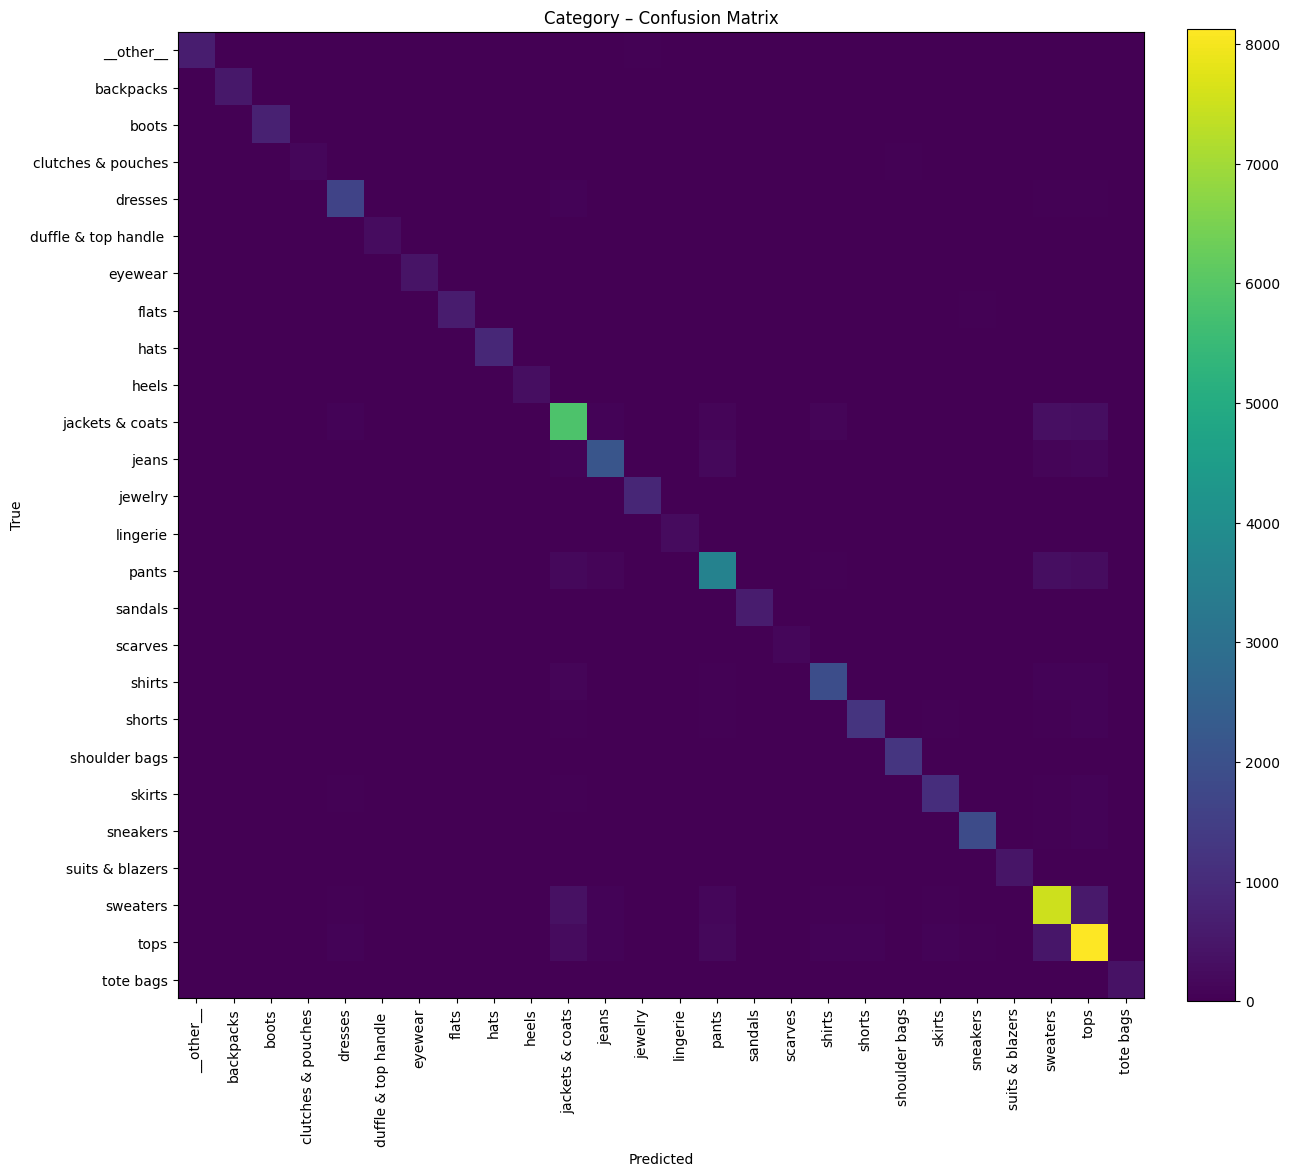

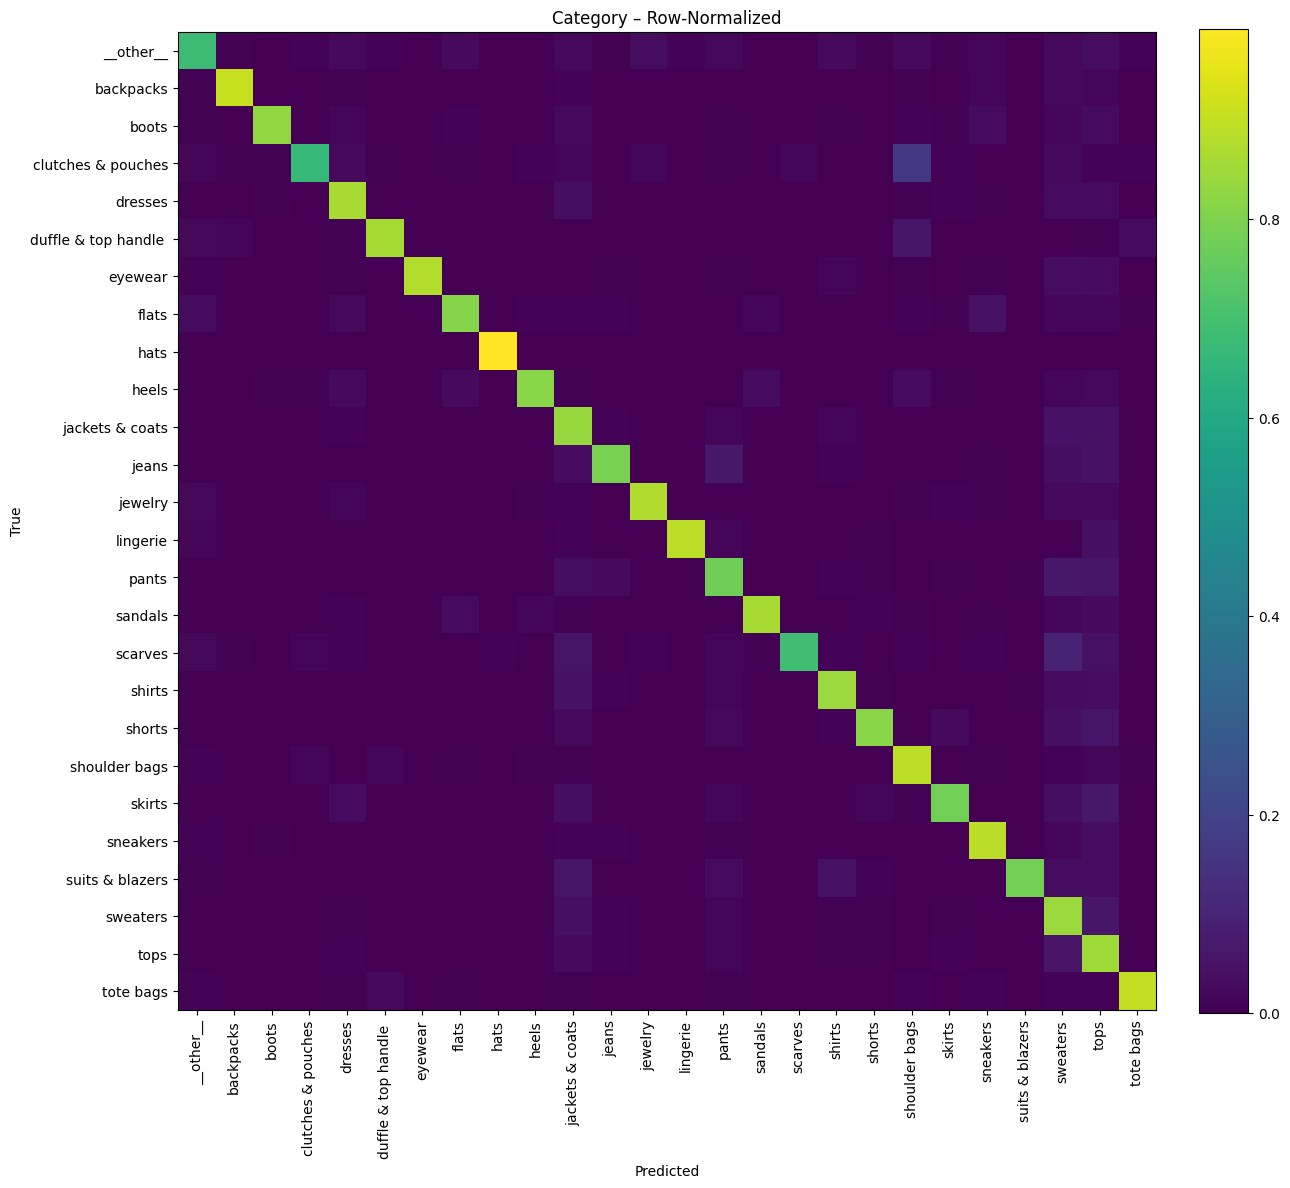

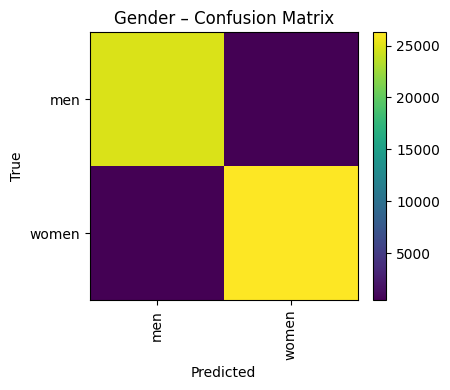

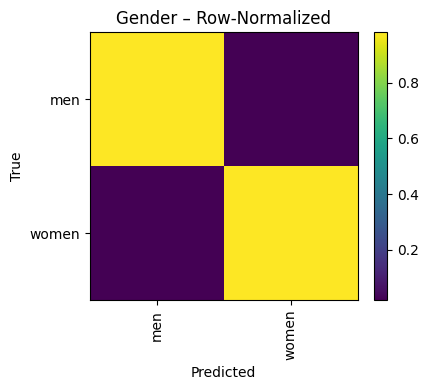

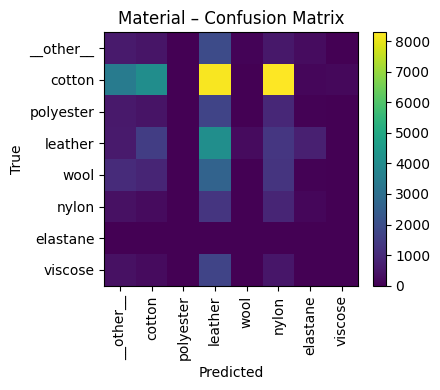

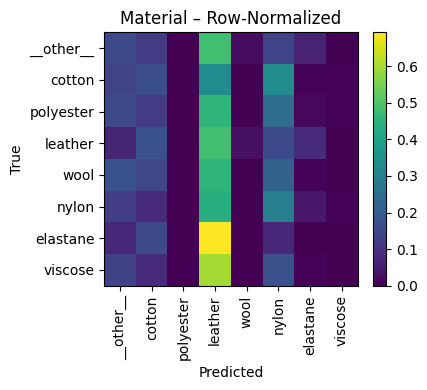

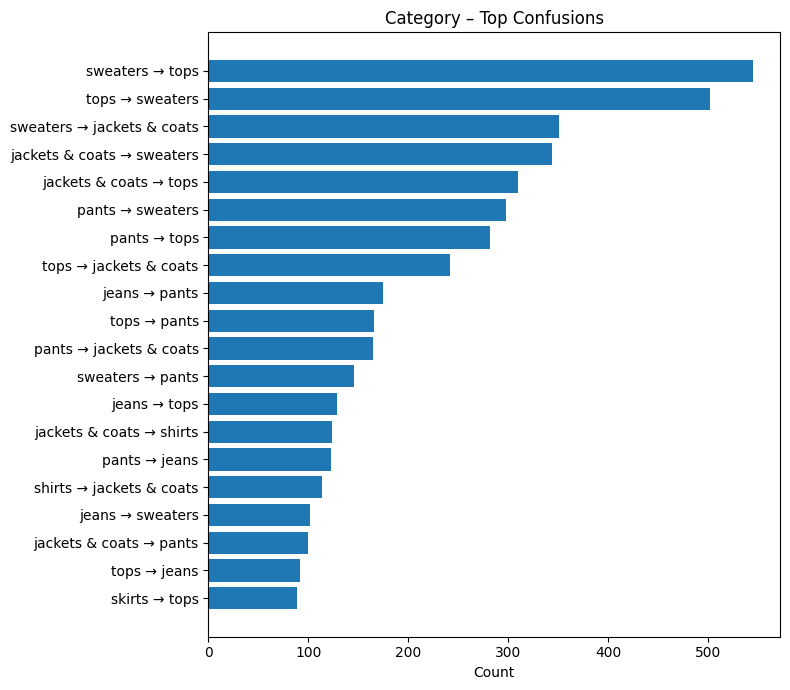

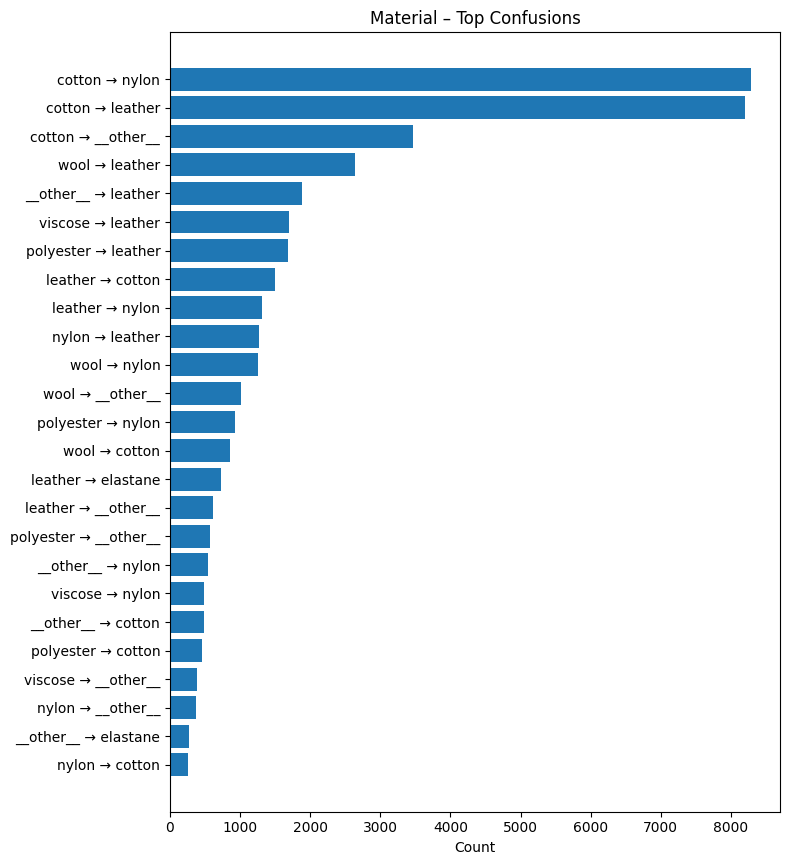

In [58]:
# # ---------- build or load your matrices ----------
# cm_cat = np.load("runs/eval/confmat_category.npy")   if 'cm_cat' not in globals() else cm_cat
# cm_gen = np.load("runs/eval/confmat_gender.npy")     if 'cm_gen' not in globals() else cm_gen
# cm_mat = np.load("runs/eval/confmat_material.npy")   if 'cm_mat' not in globals() else cm_mat

# ---------- print (category) ----------
# plot full or truncated corners
plot_confmat(cm_cat, idx2name=id2label, title="Category – Confusion Matrix", normalize=False, max_classes=30)
plot_confmat(cm_cat, idx2name=id2label, title="Category – Row-Normalized", normalize=True, max_classes=30)

plot_confmat(cm_gen, idx2name=id2gen,   title="Gender – Confusion Matrix", normalize=False)
plot_confmat(cm_gen, idx2name=id2gen,   title="Gender – Row-Normalized", normalize=True)

plot_confmat(cm_mat, idx2name=id2mat,   title="Material – Confusion Matrix", normalize=False, max_classes=30)
plot_confmat(cm_mat, idx2name=id2mat,   title="Material – Row-Normalized", normalize=True, max_classes=30)

# top confusions bars
plot_top_confusions_bar(cm_cat, idx2name=id2label, k=20, min_support=25, title="Category – Top Confusions")
plot_top_confusions_bar(cm_mat, idx2name=id2mat,   k=25, min_support=20, title="Material – Top Confusions")

In [61]:
def macro_f1(y_true, y_pred, C):
    f1s = []
    for c in range(C):
        tp = ((y_true==c) & (y_pred==c)).sum()
        fp = ((y_true!=c) & (y_pred==c)).sum()
        fn = ((y_true==c) & (y_pred!=c)).sum()
        prec = tp / max(1, tp+fp)
        rec  = tp / max(1, tp+fn)
        f1   = 0.0 if (prec==0 and rec==0) else (2*prec*rec)/(prec+rec+1e-12)
        f1s.append(f1)
    return float(np.mean(f1s))

if y_cat_true.size:
    print("Label macro-F1:", macro_f1(y_cat_true, y_cat_pred, len(label_vocab)))

if y_mat_true.size:
    print("Material macro-F1:", macro_f1(y_mat_true, y_mat_pred, len(mat_vocab)))


Label macro-F1: 0.8445001199989236
Material macro-F1: 0.09370094208599004


In [66]:
# ----- C) Top-K Accuracy
from typing import Optional
def topk_correct(logits: torch.Tensor, y_true: torch.Tensor, k: int = 3, mask: Optional[torch.Tensor] = None):
    """
    Returns (#correct_in_topk, #evaluated).
    If mask is provided (bool tensor), only masked rows are evaluated.
    """
    if mask is not None:
        if mask.ndim > 0:
            logits = logits[mask]
            y_true = y_true[mask]
        else:
            # scalar mask -> either all or none
            if not bool(mask.item() if torch.is_tensor(mask) else mask):
                return 0, 0

    if y_true.numel() == 0:
        return 0, 0

    # top-k indices
    topk_idx = torch.topk(logits, k=k, dim=-1).indices  # [B,k]
    # compare y_true expanded vs topk
    correct = (topk_idx == y_true.unsqueeze(1)).any(dim=1)  # [B]
    return int(correct.sum().item()), int(correct.numel())

topk = {"category_top3": 0.0, "material_top3": 0.0}
num = {"cat": 0, "mat": 0}

model.eval()
with torch.no_grad():
    bar = tqdm(test_loader, total=len(test_loader), desc="Top-K Eval", leave=True)
    for batch in bar:
        images = batch["images"].to(device)
        out = model(images)

        # ---- category top-3 ----
        if "logits_category" in out and batch.get("y_cat") is not None:
            c_ok, c_n = topk_correct(out["logits_category"], batch["y_cat"].to(out["logits_category"].device), k=3)
            topk["category_top3"] += c_ok
            num["cat"] += c_n

        # ---- material top-3 (masked valid rows only) ----
        if "logits_material" in out and batch.get("y_material") is not None:
            y_mat = batch["y_material"].to(out["logits_material"].device)
            mask = (y_mat >= 0)
            m_ok, m_n = topk_correct(out["logits_material"], y_mat, k=3, mask=mask)
            topk["material_top3"] += m_ok
            num["mat"] += m_n

        # running averages on the bar
        cat_avg = (topk["category_top3"] / max(1, num["cat"]))
        mat_avg = (topk["material_top3"] / max(1, num["mat"]))
        bar.set_postfix({
            "cat@3": f"{cat_avg:.4f}",
            "mat@3": f"{mat_avg:.4f}",
            "seen_cat": num["cat"],
            "seen_mat": num["mat"],
        })

# finalize
topk["category_top3"] = topk["category_top3"] / max(1, num["cat"])
topk["material_top3"] = topk["material_top3"] / max(1, num["mat"])
print({"category_top3": topk["category_top3"], "material_top3": topk["material_top3"]})

Top-K Eval:   0%|          | 0/815 [00:00<?, ?it/s]

{'category_top3': 0.9561479263822519, 'material_top3': 0.4220546183814075}


In [78]:
def _to_np(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

def _argmax_name(logits, id2name):
    idx = int(logits.argmax(dim=-1).item())
    return id2name.get(idx, str(idx)), idx

def _true_name(y, id2name):
    if y is None:
        return None, None
    if torch.is_tensor(y):
        y = int(y.item())
    return id2name.get(y, str(y)), y

def _decode_cap_target(tokens_1d, tok):
    ids = []
    for t in tokens_1d.tolist():
        if t == tok.pad_id:
            continue
        ids.append(t)
    return tok.decode(ids)

# Build id→name maps once
id2label = {v:k for k,v in label_vocab.items()}
id2gen   = {v:k for k,v in gen_vocab.items()}
id2mat   = {v:k for k,v in mat_vocab.items()}

def show_samples_with_progress(model, loader, tok, device, n_show=12, max_len=20):
    model.eval()
    shown = 0
    print("\n=== SAMPLE COMPARISONS (with progress) ===")

    with torch.no_grad():
        # batch-level progress bar
        for batch in tqdm(loader, total=len(loader), desc="Batches", leave=True):
            images = batch["images"].to(device)
            # forward (classification heads)
            out = model(images)

            # generate captions (bar per-batch for clarity)
            gen_ids = model.generate(images, bos_id=tok.bos_id, eos_id=tok.eos_id, max_len=max_len)

            B = images.size(0)
            to_print = min(B, n_show - shown)
            if to_print <= 0:
                break

            # per-sample progress bar inside this batch
            for i in tqdm(range(to_print), desc="Printing samples", leave=False):
                # -------- captions ----------
                gen_txt = tok.decode(gen_ids[i].tolist())
                if "caption_raw" in batch and batch["caption_raw"][i]:
                    gt_txt = batch["caption_raw"][i]
                elif batch.get("cap_tgt") is not None:
                    gt_txt = _decode_cap_target(batch["cap_tgt"][i], tok)
                else:
                    gt_txt = "(no reference)"

                # -------- category ----------
                cat_pred_name = None; cat_true_name = None
                if "logits_category" in out:
                    cat_pred_name, _ = _argmax_name(out["logits_category"][i:i+1], id2label)
                if batch.get("y_cat") is not None:
                    cat_true_name, _ = _true_name(batch["y_cat"][i], id2label)

                # -------- gender ----------
                gen_pred_name = None; gen_true_name = None
                if "logits_gender" in out:
                    gen_pred_name, _ = _argmax_name(out["logits_gender"][i:i+1], id2gen)
                if batch.get("y_gender") is not None:
                    gen_true_name, _ = _true_name(batch["y_gender"][i], id2gen)

                # -------- material ----------
                mat_pred_name = None; mat_true_name = None
                if "logits_material" in out:
                    mat_pred_name, _ = _argmax_name(out["logits_material"][i:i+1], id2mat)
                if batch.get("y_material") is not None:
                    ymat = int(batch["y_material"][i].item())
                    if ymat >= 0:
                        mat_true_name = id2mat.get(ymat, str(ymat))

                # -------- optional metadata ----------
                meta = batch.get("meta", [{}]*B)[i]
                pid  = meta.get("product_id", "N/A")
                comp = meta.get("input_composition", meta.get("composition", "N/A"))
                iname = meta.get("input_name", None)

                print("-" * 90)
                print(f"[{shown:02d}] ProductID: {pid} | Composition: {comp}")
                if iname:
                    print(f"     Input Name(meta): {iname}")
                print(f"     GEN: {gen_txt}")
                print(f"     GT : {gt_txt}")

                if (cat_pred_name is not None) or (cat_true_name is not None):
                    print(f"     Category  → pred: {cat_pred_name} | true: {cat_true_name}")
                if (gen_pred_name is not None) or (gen_true_name is not None):
                    print(f"     Gender    → pred: {gen_pred_name} | true: {gen_true_name}")
                if (mat_pred_name is not None) or (mat_true_name is not None):
                    print(f"     Material  → pred: {mat_pred_name} | true: {mat_true_name}")

                shown += 1
                if shown >= n_show:
                    break
            if shown >= n_show:
                break

# Run it (choose val_loader or test_loader)
show_samples_with_progress(model, val_loader, tok, device, n_show=30, max_len=20)



=== SAMPLE COMPARISONS (with progress) ===


Batches:   0%|          | 0/509 [00:00<?, ?it/s]

Printing samples:   0%|          | 0/30 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------
[00] ProductID: N/A | Composition: N/A
     GEN: indigo denim jacket
     GT : Blue Faded Elshar Jogg Jacket
     Category  → pred: jackets & coats | true: jackets & coats
     Gender    → pred: men | true: men
     Material  → pred: nylon | true: cotton
------------------------------------------------------------------------------------------
[01] ProductID: N/A | Composition: N/A
     GEN: blue denim jacket
     GT : Blue Faded Elshar Jogg Jacket
     Category  → pred: jackets & coats | true: jackets & coats
     Gender    → pred: men | true: men
     Material  → pred: nylon | true: cotton
------------------------------------------------------------------------------------------
[02] ProductID: N/A | Composition: N/A
     GEN: blue denim jacket
     GT : Blue Faded Elshar Jogg Jacket
     Category  → pred: jackets & coats | true: jackets & coats
     Gender    → pred: men | true: men
     Mater

In [86]:
import pickle
from tqdm.auto import tqdm  # auto selects best available bar for Jupyter/console

model.eval()
rows = []

with torch.no_grad():
    with tqdm(val_loader, total=len(val_loader), desc="Predict (val)", leave=True) as bar:
        for batch in bar:
            images = batch["images"].to(device)
            out = model(images)

            pred_cat = _argmax(out["logits_category"]) if "logits_category" in out else None
            pred_gen = _argmax(out["logits_gender"])   if "logits_gender"   in out else None
            pred_mat = _argmax(out["logits_material"]) if "logits_material" in out else None

            y_cat = _to_np(batch["y_cat"]) if batch.get("y_cat") is not None else None
            y_gen = _to_np(batch["y_gender"]) if batch.get("y_gender") is not None else None
            y_mat = _to_np(batch["y_material"]) if batch.get("y_material") is not None else None

            gen_ids = model.generate(images, bos_id=tok.bos_id, eos_id=tok.eos_id, max_len=20)
            cap_tgt = batch.get("cap_tgt")
            if cap_tgt is not None:
                cap_tgt = _to_np(cap_tgt)

            # Ensure dataset returned `index`
            idxs = batch.get("idxs")
            if idxs is None:
                raise KeyError("Batch missing 'index'. Make sure FashionGenH5.__getitem__ returns it.")

            B = images.size(0)
            for i in range(B):
                row = {
                    "index": int(idxs[i]),
                    "pred_cat": int(pred_cat[i]) if pred_cat is not None else None,
                    "pred_gen": int(pred_gen[i]) if pred_gen is not None else None,
                    "pred_mat": int(pred_mat[i]) if pred_mat is not None else None,
                    "true_cat": int(y_cat[i]) if y_cat is not None else None,
                    "true_gen": int(y_gen[i]) if y_gen is not None else None,
                    "true_mat": int(y_mat[i]) if y_mat is not None else None,
                    "gen_caption": _decode_caption_tokens(gen_ids[i].tolist(), tok),
                    "ref_caption": (
                        _decode_caption_tokens(cap_tgt[i].tolist(), tok)
                        if cap_tgt is not None else
                        (batch.get("caption_raw", [""]*B)[i] if batch.get("caption_raw") is not None else "")
                    ),
                }
                rows.append(row)

# Save DataFrame + PKL
df = pd.DataFrame(rows).set_index("index").sort_index()
print("DF shape:", df.shape)

SAVE_DIR = Path("runs/preds_val")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

PKL_PATH = SAVE_DIR / "val_predictions.pkl"
df.to_pickle(PKL_PATH)
print(f"✅ Saved PKL with index: {PKL_PATH}")

# Minimal map
minimal = {
    int(idx): {
        "pred_cat": int(r["pred_cat"]) if pd.notna(r["pred_cat"]) else None,
        "true_cat": int(r["true_cat"]) if pd.notna(r["true_cat"]) else None,
        "pred_gen": int(r["pred_gen"]) if pd.notna(r["pred_gen"]) else None,
        "true_gen": int(r["true_gen"]) if pd.notna(r["true_gen"]) else None,
        "pred_mat": int(r["pred_mat"]) if pd.notna(r["pred_mat"]) else None,
        "true_mat": int(r["true_mat"]) if pd.notna(r["true_mat"]) else None,
    }
    for idx, r in df[["pred_cat","true_cat","pred_gen","true_gen","pred_mat","true_mat"]].fillna(np.nan).iterrows()
}

PKL_MAP_PATH = SAVE_DIR / "val_predictions_minimal.pkl"

Predict (val):   0%|          | 0/509 [00:00<?, ?it/s]

DF shape: (32528, 8)
✅ Saved PKL with index: runs/preds_val/val_predictions.pkl


In [87]:
with open(PKL_MAP_PATH, "wb") as f:
    pickle.dump(minimal, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"✅ Saved minimal PKL (index→labels): {PKL_MAP_PATH}")

✅ Saved minimal PKL (index→labels): runs/preds_val/val_predictions_minimal.pkl


In [89]:
# ---------- Example: load back & inspect ----------
df_loaded = pd.read_pickle(PKL_PATH)
print("Loaded:", df_loaded.shape, "| index name:", df_loaded.index.name)
if len(df_loaded):
    ex_idx = df_loaded.index[0:10]
    print("Example row @index", ex_idx, "→", df_loaded.loc[ex_idx].to_dict())

Loaded: (32528, 8) | index name: index
Example row @index Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='index') → {'pred_cat': {0: 10, 1: 10, 2: 10, 3: 10, 4: 11, 5: 11, 6: 11, 7: 11, 8: 10, 9: 10}, 'pred_gen': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 'pred_mat': {0: 5, 1: 5, 2: 5, 3: 1, 4: 0, 5: 0, 6: 0, 7: 5, 8: 5, 9: 5}, 'true_cat': {0: 10, 1: 10, 2: 10, 3: 10, 4: 11, 5: 11, 6: 11, 7: 11, 8: 10, 9: 10}, 'true_gen': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 'true_mat': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 3, 9: 3}, 'gen_caption': {0: 'indigo denim jacket', 1: 'blue denim jacket', 2: 'blue denim jacket', 3: 'blue denim jacket', 4: 'navy skinny jeans', 5: 'grey faded skinny jeans', 6: 'grey distressed slim jeans', 7: 'blue faded & distressed slim jeans', 8: 'black leather biker jacket', 9: 'black leather & wool biker jacket'}, 'ref_caption': {0: 'blue faded elshar jogg jacket', 1: 'blue faded elshar jogg jacket', 2: '